# Task 8 - Find the best Random Forest through Random Search

In order to **maximize the performance of the random forest**, we can perform a **random search** for better hyperparameters. This will randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values (read best model with hyperparameters) that perform the best. 

### Task Requirements
- Build a RandomForest for the above dataset (not one but many with different sets of parameters)
- Explore RandomizedSearchCV in Scikit-learn documentation
- Create a parameter grid with these values
    - n_estimators : between 10 and 200
    - max_depth : choose between 3 and 20
    - max_features : ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1))
    - max_leaf_nodes : choose between 10 to 50
    - min_samples_split : choose between 2, 5, or 10
    - bootstrap : choose between True or False
- Create the estimator (RandomForestClassifier)
- Create the RandomizedSearchCV with estimator, parameter grid, scoring on roc auc, n_iter = 10, random_state=RSEED(50) for same reproducible results
- Fit the model
- Explore the best model parameters
- Use the best model parameters to predict
- Plot the best model ROC AUC Curve
- Plot the Confusion Matrix
- Write any insights or observations you found in the last

## Random Forest Theory revisited

### Random Forest = Decision Tree + Bagging + Random subsets of features

The Random Forest is a model made up of many `decision trees`. Rather than just simply averaging the prediction of trees (which we could call a **forest**), this model uses two key concepts that gives it the name random:
- Random sampling of training data points when building trees
- Random subsets of features considered when splitting nodes

To be more clear, this takes the idea of a single decision tree, and creates an _ensemble_ model out of hundreds or thousands of trees to reduce the variance. 

Each tree is trained on a random set of the observations, and for each split of a node, only a `subset of the features` are used for making a split. When making predictions, the random forest `averages the predictions` for each of the individual decision trees for each data point in order to arrive at a final classification.

### Bagging

### Random sampling of training observations

- **Training**: each tree in a random forest learns from a **random sample** of the data points. The samples are drawn with replacement, known as **bootstrapping**, which means that some samples will be used multiple times in a single tree. The idea is that by training each tree on different samples, although each tree might have high variance with respect to a particular set of the training data, overall, the entire forest will have lower variance but not at the cost of increasing the bias.

- **Testing**: predictions are made by **averaging the predictions** of each decision tree. This procedure of training each individual learner on different bootstrapped subsets of the data and then averaging the predictions is known as **bagging**, short for **bootstrap aggregating**.

### Random Subsets of features for splitting nodes
Only a subset of all the features are considered for splitting each node in each decision tree. Generally this is set to `sqrt(n_features)` for classification meaning that if there are 16 features, at each node in each tree, only 4 random features will be considered for splitting the node. 

### Let us see if our theory holds good in the same dataset we used for building Decision Tree

# Behavioral Risk Factor Surveillance System

[Behavioral Risk Factor Surveillance System](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system)

The objective of the BRFSS is to collect uniform, state-specific data on preventive health practices and risk behaviors that are linked to chronic diseases, injuries, and preventable infectious diseases in the adult population. Factors assessed by the BRFSS include tobacco use, health care coverage, HIV/AIDS knowledge or prevention, physical activity, and fruit and vegetable consumption. Data are collected from a random sample of adults (one per household) through a telephone survey.

The Behavioral Risk Factor Surveillance System (BRFSS) is the nation's premier system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services. Established in 1984 with 15 states, BRFSS now collects data in all 50 states as well as the District of Columbia and three U.S. territories. BRFSS completes more than 400,000 adult interviews each year, making it the largest continuously conducted health survey system in the world.

The following data set is from the Centers for Disease Control and Prevention (CDC) and includes socioeconomic and lifestyle indicators for hundreds of thousands of individuals. The objective is to predict the overall health of an individual: either 0 for poor health or 1 for good health. We'll limit the data to 100,000 individuals to speed up training.

Or, if you have the gut to take it, please pass the entire data and have fun!!!

This problem is imbalanced (far more of one label than another) so for assessing performance, we'll use recall, precision, receiver operating characteristic area under the curve (ROC AUC), and also plot the ROC curve. Accuracy is not a useful metric when dealing with an imbalanced problem. **Why????**

## Data Acquisition
Go to Kaggle Competition page and pull the dataset of 2015

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import  seaborn as sns
RSEED=50

In [2]:
df = pd.read_csv('data/2015.csv').sample(100000, random_state = RSEED)
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
383119,49.0,4.0,b'05192015',b'05',b'19',b'2015',1100.0,2.015009e+09,2.015009e+09,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
55536,9.0,9.0,b'09232015',b'09',b'23',b'2015',1100.0,2.015005e+09,2.015005e+09,1.0,...,2.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
267093,34.0,10.0,b'11052015',b'11',b'05',b'2015',1100.0,2.015011e+09,2.015011e+09,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
319092,41.0,4.0,b'04062015',b'04',b'06',b'2015',1100.0,2.015002e+09,2.015002e+09,1.0,...,2.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0
420978,54.0,5.0,b'05112015',b'05',b'11',b'2015',1100.0,2.015004e+09,2.015004e+09,NaN,...,1.0,1.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0


### Data Exploration
- Find how many features
- Find how many samples
- Find how many missing data
- Find how many categorical features
- And many more

In [3]:
df = df.select_dtypes('number')
print("Amount of features in the dataset: ", len(df.columns))
print("Amount of Samples in the data: ", len(df))
print("Amount of missing data cells", df.isna().sum().sum())
data_types = df.dtypes
print("Amount of Categorical features,", data_types[data_types == 'object'].sum())
#There are no categorical features


Amount of features in the dataset:  323
Amount of Samples in the data:  100000
Amount of missing data cells 14680740
Amount of Categorical features, 0


### Label Distribution
RFHLTH is the label for this dataset

### Explore the label

In [4]:
df['_RFHLTH']

383119    1.0
55536     1.0
267093    1.0
319092    1.0
420978    1.0
         ... 
223705    1.0
193441    1.0
39766     1.0
142057    1.0
386390    1.0
Name: _RFHLTH, Length: 100000, dtype: float64

### Find what are the values inside the label

In [5]:
df['_RFHLTH'].value_counts()

_RFHLTH
1.0    81140
2.0    18579
9.0      281
Name: count, dtype: int64

### Label feature
- Keep only 1.0 values
- Make 2.0 as 0.0 
- Discard all other values
- Rename the feature as `label`

In [6]:
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()
df = df.rename(columns = {'_RFHLTH': 'label'})
df['label'].value_counts()

label
1.0    81140
0.0    18579
Name: count, dtype: int64

### What do you see?

In [7]:
#I see a Y output with two categories. 

Some housekeeping to make things smooth...

In [8]:
# Remove columns with missing values
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])

## Split Data into Training and Testing Set

Save 30% for testing

In [9]:
from sklearn.model_selection import train_test_split


labels = np.array(df.pop('label'))


train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

#### Imputation of Missing values

We'll fill in the missing values with the mean of the column. It's important to note that we fill in missing values in the test set with the mean of columns in the training data. This is necessary because if we get new data, we'll have to use the training data to fill in any missing values. 

In [10]:
train = train.fillna(train.mean())
test = test.fillna(train.mean())

# Features for feature importances, we will use this later below in this notebook
features = list(train.columns)

In [11]:
train.shape

(69803, 313)

In [12]:
test.shape

(29916, 313)

### Task Requirements
- Build a RandomForest for the above dataset (not one but many with different sets of parameters)
- Explore RandomizedSearchCV in Scikit-learn documentation
- Create a parameter grid with these values
    - n_estimators : between 10 and 200
    - max_depth : choose between 3 and 20
    - max_features : ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1))
    - max_leaf_nodes : choose between 10 to 50
    - min_samples_split : choose between 2, 5, or 10
    - bootstrap : choose between True or False
- Create the estimator (RandomForestClassifier)
- Create the RandomizedSearchCV with estimator, parameter grid, scoring on roc auc, n_iter = 10, random_state=RSEED(50) for same reproducible results
- Fit the model
- Explore the best model parameters
- Use the best model parameters to predict
- Plot the best model ROC AUC Curve
- Plot the Confusion Matrix
- Write any insights or observations you found in the last

### Import RandomizedSearchCV

In [13]:
from sklearn.model_selection import RandomizedSearchCV

### Import RandomForestClassifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

### Set the parameter grid according to the requirements above as a dictionary

In [15]:
param_grid = {
    'n_estimators':  [10, 50, 100, 200],
    'max_depth': [3, 10, 20],
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)), 
    'max_leaf_nodes': [10, 25, 50],
    'min_samples_split':  [2, 5, 10],
    'bootstrap': [True, False]
}


### Create the estimator with RSEED

In [16]:
random_forest = RandomForestClassifier(random_state=RSEED)

### Create the Random Search model with cv=3, n_iter=10, scoring='roc_auc', random_state='RSEED'

In [17]:
random_search = RandomizedSearchCV(
    random_forest,
    param_distributions=param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=3,
    random_state=RSEED,
    n_jobs=-1,
)

### Fit the model 
Note: It will take long time (around 20 - 1 hour depending on your computer specs). Good time to reload yourself with some energy or take a quick beauty nap!!!

In [18]:
random_search.fit(train, train_labels)

D:\Developments\Python\ML\BestRandomForest\.venv\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Developments\Python\ML\BestRandomForest\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Developments\Python\ML\BestRandomForest\.venv\lib\site-packages\sklearn\base.py", line 1344, in wrapper
    estimator._validate_params()
  File "D:\Developments\Python\ML\BestRandomForest\.venv\lib\site-packages\sklearn\base.py", line 666, in _validate_

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=50),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 10, 20],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [10, 25, 50],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   random_state=50, scoring='roc_auc')

### Explore the best parameters

In [19]:
random_search.best_params_

{'n_estimators': 10,
 'min_samples_split': 5,
 'max_leaf_nodes': 50,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

- First thing you'll notice is that the hyperparameter values are **not default** values.
- Awesome. You've **tuned the hyperparameters**. Well done!!!

### Use the Best Model

Choose the best model as you find in under `best_estimator_`

In [20]:
best_model = random_search.best_estimator_
best_model

RandomForestClassifier(bootstrap=False, max_depth=20, max_leaf_nodes=50,
                       min_samples_split=5, n_estimators=10, random_state=50)

### Make the predictions with the chosen best model

In [50]:
best_model.fit(train, train_labels)

best_model_prediction_test = best_model.predict(test)
best_model_prediction_train = best_model.predict(train)

y_train_prob = best_model.predict_proba(train)[:, 1]
y_test_prob = best_model.predict_proba(test)[:, 1]

### Get the node counts and maximum depth of the random forest

In [48]:
for i, tree in enumerate(best_model):
    node_count = tree.tree_.node_count
    max_depth = tree.tree_.max_depth
    print(f"Node counts:{node_count}, maximun depth:{max_depth}")
    


Node counts:99, maximun depth:10
Node counts:99, maximun depth:11
Node counts:99, maximun depth:10
Node counts:99, maximun depth:11
Node counts:99, maximun depth:12
Node counts:99, maximun depth:11
Node counts:99, maximun depth:12
Node counts:99, maximun depth:13
Node counts:99, maximun depth:10
Node counts:99, maximun depth:10


## Plot the ROC AUC Scores for training and testing data

In [63]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [64]:
fpr_train, tpr_train, _ = roc_curve(train_labels, y_train_prob)
roc_auc_train = roc_auc_score(train_labels, y_train_prob)
print(f"AUC score training: {roc_auc_train}")

AUC score training: 0.8735869431264123


In [65]:
fpr_test, tpr_test, _ = roc_curve(test_labels, y_test_prob)
roc_auc_test = roc_auc_score(test_labels, y_test_prob)
print(f"AUC score test: {roc_auc_test}")

AUC score test: 0.8655203558300322


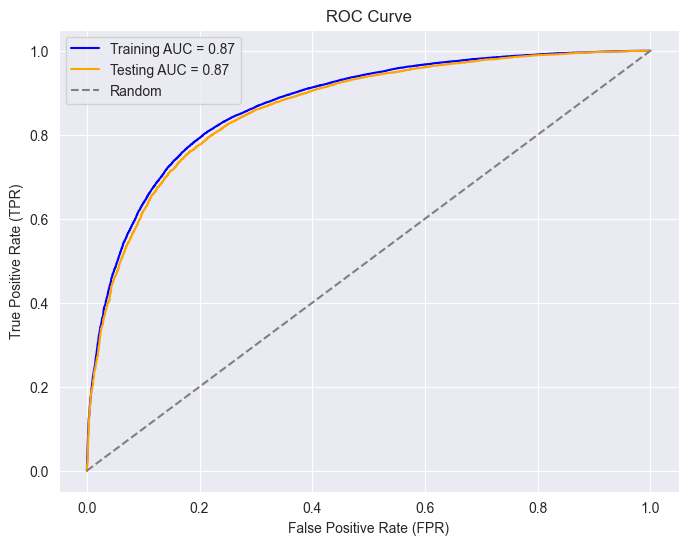

In [66]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Training AUC = {roc_auc_train:.2f}', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Testing AUC = {roc_auc_test:.2f}', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Helper function to Evaluate model

In [67]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend()
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


### Evaluate the best model
- Plot the ROC AUC Curve

Recall Baseline: 1.0 Test: 1.0 Train: 1.0
Precision Baseline: 0.81 Test: 1.0 Train: 1.0
Roc Baseline: 0.5 Test: 0.87 Train: 0.87


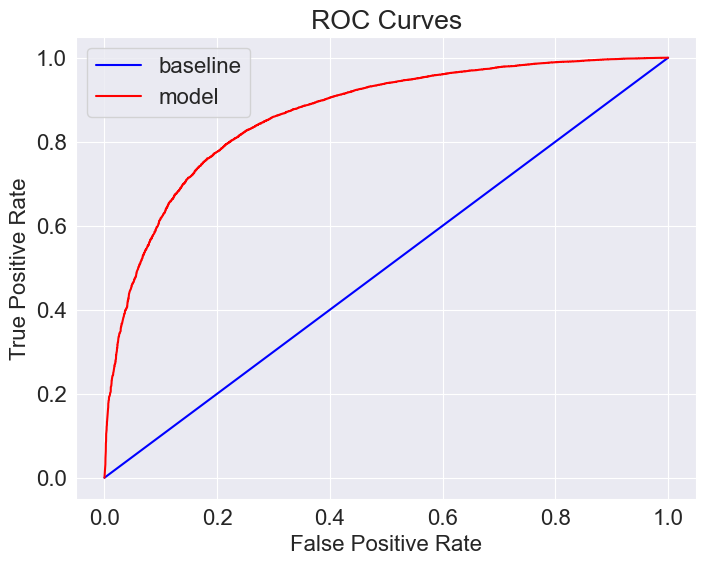

In [71]:
model_evaluation = evaluate_model(test_labels, y_test_prob, train_labels, y_train_prob)

### Confusion Matrix Helper function

In [72]:
from sklearn.metrics import confusion_matrix
import itertools

#  Helper function to plot Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Please do not run the below 2 cells....
## It is given only for your comparision of Decision Tree, RandomForest and your very own Best RandomForest

Confusion matrix, without normalization
[[ 2677  2897]
 [ 3103 21239]]


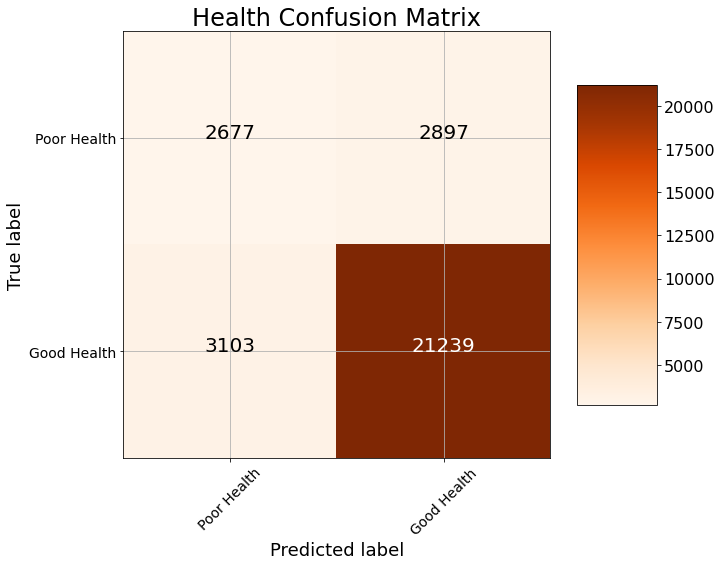

In [30]:
# Decision Tree Confusion Matrix

Confusion matrix, without normalization
[[ 2437  3137]
 [ 1011 23331]]


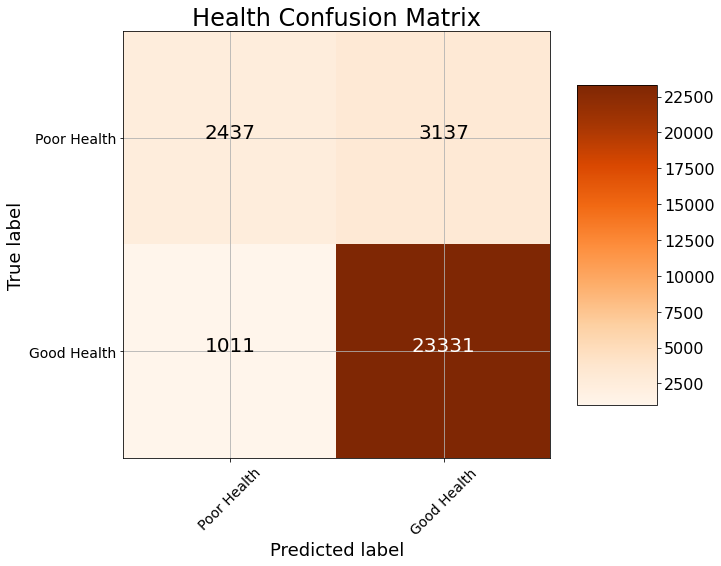

In [26]:
# Random Forest

### Evaluate the best model
- Plot Confusion Matrix

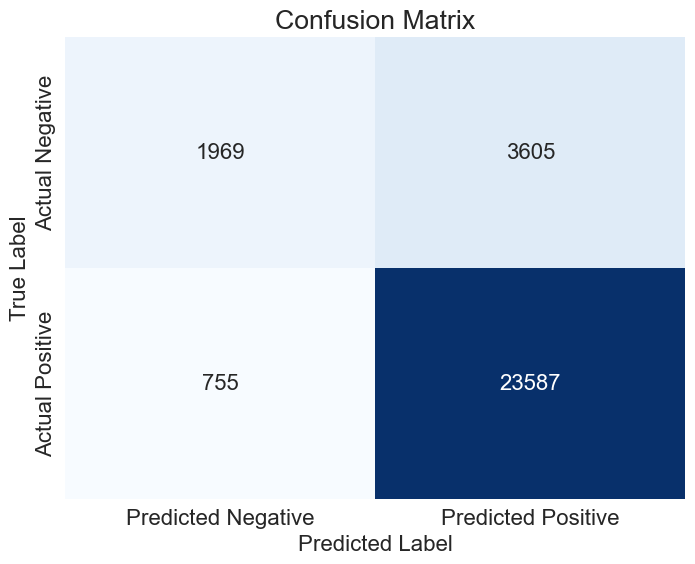

In [79]:
conf_matrix = confusion_matrix(test_labels, best_model_prediction_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Observations / Insights ???

### Bonus: What if you want to explain your best RandomForest to your boss on the way it split the features??? Do not fret. Capture the estimator and convert them into a .png and present it in the meeting and get accolodes.

In [85]:
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

estimator = best_model.estimators_[1]
#f = open("tree_from_optimized_forest.dot", "x")

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=train.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)

In [84]:
call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])
Image('tree_from_optimized_forest.png')

FileNotFoundError: [WinError 2] The system cannot find the file specified